#A simple autoencoder test
Bottleneck consists of a single number, which determines the fraction of the image covered in black squares

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from matplotlib import pyplot as plt

In [2]:
# Decoder goes here
N_image = 28 # Size of (square) input image

def regions(x):
    # x represents the fraction of the image full of ones
    img = np.zeros(N_image*N_image).reshape(N_image,N_image) - 1
    Q = int(np.floor(x*N_image))
    img[:,0:Q] = 1
    return img

[ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


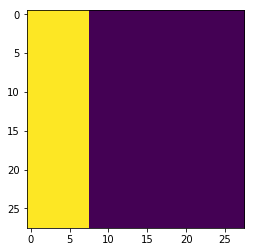

In [3]:
# And here's a test to see that the decoder does what we expect:
plt.imshow(regions(0.3))
print regions(0.3)[int(N_image/2),:]

In [4]:
#Making dataset
N_train = 1000
noise = 0.3

train_images = []
train_labels = []
for i in range(N_train):
    x = np.random.uniform()
    train_labels.append(np.int(np.round(x,1)*10))
    img = regions(x) + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image)
    train_images.append(img)

train_images = np.array(train_images)
train_images_transposed = np.array([img.transpose() for img in train_images])
train_images = np.concatenate((train_images, train_images_transposed))
train_images = train_images.reshape(2*N_train,N_image,N_image,1)
train_labels = np.array(train_labels)

In [5]:
print train_images.shape

(2000, 28, 28, 1)


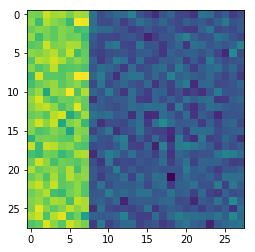

[ 1.06984622  1.23653835  1.54023483  0.48520165  0.93536147  1.18061648
  0.61062741  0.80985012  1.03132988  0.78549004  0.65888009  1.06144332
  0.86926411  0.91076877 -0.89612034 -1.00920954 -0.48377343 -1.15222106
 -1.38797913 -1.30651407 -0.42963011 -1.04402988 -1.06734749 -1.39809224
 -1.24900544 -0.78900238 -0.94903432 -1.03070272]


In [6]:
# And here's a test to check that the training images are reasonable:
plt.imshow(train_images[7,:,:,0])
plt.show()
print train_images[3,int(N_image/2),:,0]

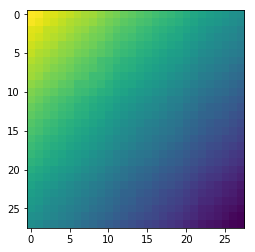

[ 0.42167763  0.38436464  0.34364897  0.31458005  0.27506963  0.23446199
  0.20348344  0.17309482  0.14027395  0.10347162  0.05056054  0.01360516
 -0.0300227  -0.05551495 -0.09275136 -0.1407002  -0.15448754 -0.19340347
 -0.22633732 -0.25462051 -0.30959975 -0.34382237 -0.38817074 -0.42663928
 -0.45744945 -0.47135675 -0.51545798 -0.54782556]


In [7]:
mean_image = np.mean(train_images,axis=0)[:,:,0]
plt.imshow(mean_image)
plt.show()
print mean_image[int(N_image/2),:]

In [8]:
from __future__ import division

def normalize_meanstd(a, axis=None):
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std, mean, std

train_images_std, mean, std = normalize_meanstd(train_images, axis=(1,2))

In [9]:
#Lambda Layer (Decoder)
def make_regions(x):
    img = tf.to_float(tf.convert_to_tensor(np.repeat(np.arange(N_image),N_image).reshape(N_image,N_image)))
    #np.zeros(N_image*N_image).reshape(N_image,N_image)
    #Q = tf.math.int(tf.math.floor(x*N_image))#int(np.floor(x*N_image))
    #condi = tf.math.greater(img, x)
    unity = tf.convert_to_tensor(np.repeat(1., N_image*N_image).reshape(N_image, N_image))
    zeros = tf.convert_to_tensor(np.zeros(N_image*N_image).reshape(N_image, N_image))
    tf.where(img > x, unity, zeros)
    return img

In [10]:
model = models.Sequential()
filt_size = 3
fs = filt_size
model.add(layers.Conv2D(32, (fs, fs), activation='relu', padding="same", input_shape = (N_image,N_image,1),strides=(1,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3136, activation='relu'))
model.add(layers.Reshape((7, 7, 64)))

model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (fs, fs), activation='relu', padding="same"))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (fs, fs), activation='sigmoid', padding="same"))

#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1))
#model.add(layers.Lambda(make_regions))
model.summary()

W1003 11:29:46.956928 139730781783424 deprecation.py:506] From /home/tanmoy/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [11]:
model.compile(optimizer='RMSprop',
              loss='mean_squared_error',
              metrics=['accuracy']
             )
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])


In [12]:
model.fit(train_images, train_images, epochs=5)
#model.fit(train_images, train_labels/10., epochs=5)

Epoch 1/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.7682 - acc: 0.0000e+00
Epoch 2/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6652 - acc: 0.0000e+00
Epoch 3/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6510 - acc: 0.0000e+00
Epoch 4/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6429 - acc: 0.0000e+00
Epoch 5/5
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6377 - acc: 0.0000e+00


In [13]:
test_img = regions(0.7).reshape(28,28,1)# + np.random.normal(0,noise,N_image*N_image).reshape(N_image,N_image,1)
#test_img = test_img[:,:,0].transpose().reshape(28,28,1)
out = model.predict(np.array([test_img]))

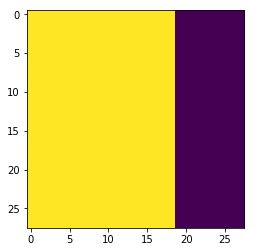

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [14]:
plt.imshow(test_img[:,:,0])
plt.show()
print test_img[0,:,0]

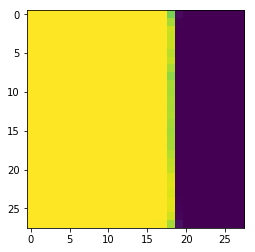

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999976 0.99986494
 0.85823756 0.0034385  0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [15]:
plt.imshow(out[0,:,:,0])
plt.show()
print out[0,15,:,0]
#print out

In [16]:
w = model.get_weights()
warr = np.array(w)
print warr[6].shape

(3136, 128)


(array([5.0000e+00, 1.2000e+01, 4.4000e+01, 1.3000e+02, 3.7600e+02,
        8.4000e+02, 1.9390e+03, 4.0880e+03, 8.0060e+03, 2.4094e+04,
        3.4213e+04, 3.6949e+04, 3.8892e+04, 3.9553e+04, 3.9769e+04,
        3.9195e+04, 3.8238e+04, 3.6332e+04, 3.1498e+04, 1.3983e+04,
        6.2750e+03, 3.4210e+03, 1.7680e+03, 8.6500e+02, 4.6000e+02,
        2.5000e+02, 1.2400e+02, 6.0000e+01, 2.2000e+01, 7.0000e+00]),
 array([-0.12523131, -0.11652011, -0.10780893, -0.09909773, -0.09038654,
        -0.08167534, -0.07296415, -0.06425296, -0.05554176, -0.04683057,
        -0.03811938, -0.02940818, -0.02069699, -0.0119858 , -0.0032746 ,
         0.00543659,  0.01414779,  0.02285898,  0.03157017,  0.04028137,
         0.04899256,  0.05770375,  0.06641494,  0.07512614,  0.08383733,
         0.09254853,  0.10125972,  0.10997091,  0.11868211,  0.1273933 ,
         0.1361045 ], dtype=float32),
 <a list of 30 Patch objects>)

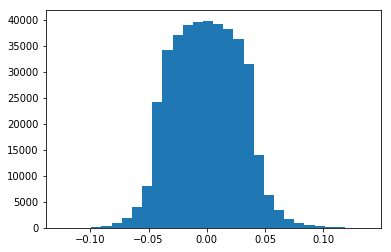

In [17]:
#plt.imshow(warr[6],aspect='auto')
plt.hist(warr[6].reshape(-1),bins=30)

In [19]:
# Run the following to see all the weights (filters) for one of the layers
#for i in np.arange(64):    
#    plt.imshow(w[2][:,:,0,i])
#    #plt.imshow(np.random.uniform(-1,1,9*9).reshape(9,9))
#    plt.show()

In [191]:
#Lambda Layer (Decoder) (TL's copy):
def make_regions(x):
    x_int = x[1]
    print x, tf.to_float(x_int)
    img = np.zeros(N_image*N_image).reshape(N_image,N_image)
    Q = int(np.floor(x_int*N_image))
    img[:,0:Q] = 1
    return img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.add(layers.Lambda(make_regions))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                36928     
__________

In [5]:
# Here's the mnist train data, for reference:

#mnist_data = np.load('mnist.npz')
#(train_images, train_labels), (test_images, test_labels) = (mnist_data['x_train'], mnist_data['y_train']), (mnist_data['x_test'], mnist_data['y_test'])

In [6]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [15]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [18]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                36928     
__________

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
 2400/60000 [>.............................] - ETA: 3:03 - loss: 1.0760 - acc: 0.6562

60000/60000 [==============================] - 134s 2ms/step - loss: 0.0197 - acc: 0.9940


In [23]:
model.predict_classes(np.array([test_images[0]]))

array([7])

In [24]:
test_labels[0]

7

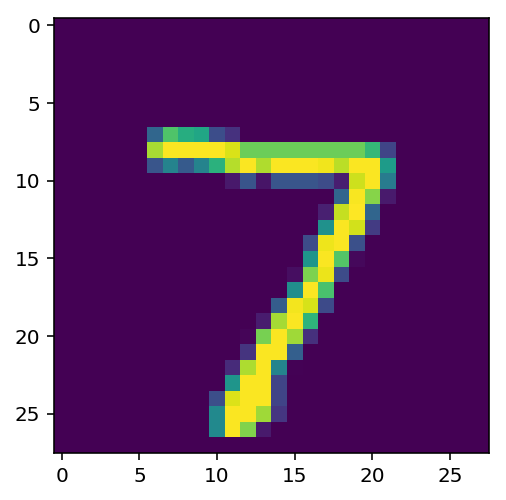

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_images[0][:,:,0])